<a href="https://colab.research.google.com/github/vijmanan04/PneumoniaDetectionCNN_Machine_Learning/blob/main/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
from google.colab import files
import json
import zipfile
import os
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mv12345","key":"519928c8e656778883351a1a3995e779"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip
!ls

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

In [ ]:
import pandas as pd
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#load data
labels = ['PNEUMONIA', 'NORMAL']
img_size = 32
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label) #go into correct label data
        class_num = labels.index(label)
        for img in os.listdir(path): #listdir makes contents in path iterable
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) #combine path and image number and read it as GrayScale
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size 128 x 128
                data.append([resized_arr, class_num]) # add data with its label
            except Exception as e:
                print(e)
    return np.array(data)
df_train = get_training_data("/content/chest_xray/train")
print("training data loaded")
df_test = get_training_data("/content/chest_xray/test")
print("testing data loaded")
df_validate = get_training_data("/content/chest_xray/val")
print("validation data loaded")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


training data loaded
testing data loaded
validation data loaded


In [ ]:
pd.DataFrame(df_train).head()[0]
#0 is normal
#1 is sick
pd.DataFrame(df_train)[0][0].shape

(32, 32)

Showing image with label 1: 


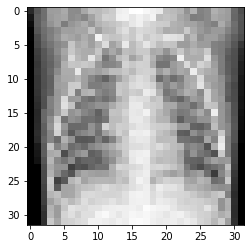

Showing image with label 0: 


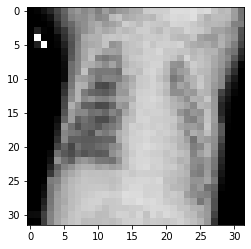

In [ ]:
def plot_one_image(data, index):
  img = data[index, 0]
  label = data[index, 1]
  print(f"Showing image with label {label}: ")
  plt.imshow(img, cmap = 'gray')
  plt.show()
plot_one_image(df_train, 5009)
plot_one_image(df_train, 1)

In [ ]:
def label_count(data):
  normal = sum(pd.DataFrame(data)[1])
  sick = len(pd.DataFrame(data)) - normal
  print(f"Normal: {normal}")
  print(f"Sick: {sick}")
label_count(df_train) #imbalanced data. Augment normal values

Normal: 1341
Sick: 3875


Showing image with label 1:


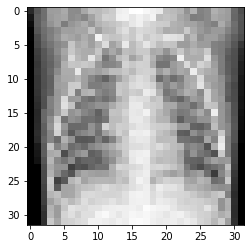

In [ ]:
def normalize(data):
  df =  pd.DataFrame(data[:,0]) / 255
  labels = pd.DataFrame(data[:,1])
  #print(pd.DataFrame(df).columns.values)
  return df, labels
norm_train, train_labels = normalize(df_train)
norm_test, test_labels = normalize(df_test)
norm_val, val_labels = normalize(df_validate)

def plot_normal_image(data, labels, index):
  img = data[0][index]
  label = labels[0][index]
  print(f"Showing image with label {label}:" )
  plt.imshow(img, cmap = 'gray')
  plt.show()
plot_normal_image(norm_train, train_labels, 5009)

In [ ]:
all_data = {
    "train_values": norm_train,
    "train_labels": train_labels,
    "test_values": norm_test,
    "test_labels": test_labels,
    "validation_values": norm_val,
    "validation_labels":val_labels
}

0


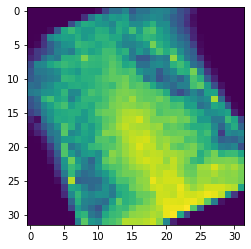

In [ ]:
# data augmentation functions
import random
import skimage as sk
from skimage import transform
from skimage import util

def random_rotation(img, label):
  rand_degree = random.uniform(-25, 25)
  return sk.transform.rotate(img, rand_degree), label

def random_noise(img, label):
  return sk.util.random_noise(img), label

def vertical_flip(img, label):
  return np.flipud(img), label

a, b = random_rotation(norm_train[0][0], train_labels[0][0])
print(b)
plt.imshow(a)
transformations = {
    '0' : random_rotation,
    '1' : random_noise,
    '2' : vertical_flip
}

In [ ]:
#augment all training data
def augment(data, labels):
  transformed_train = []
  for i in range(len(data)):
    num_transformations_to_apply = random.randint(1, len(transformations))
    num_transformations = 0
    image_to_transform = data[0][i]
    image_to_transform_label = labels[0][i]
    while num_transformations <= num_transformations_to_apply:
      key = random.randint(0, len(transformations)-1)
      image_to_transform, image_to_transform_label = transformations[f'{key}'](image_to_transform, image_to_transform_label)
      num_transformations += 1
    array = np.array([image_to_transform, image_to_transform_label])
    transformed_train.append(array)
    print(f"Finished image {i}")
  return pd.DataFrame(transformed_train)

#transformed_train = augment(norm_train, train_labels)
#img = transformed_train[0][0]
#plt.imshow(img)


In [ ]:
#augment data with label 0(normal)
def renormalize(data):
  df =  pd.DataFrame(data[0]) / 255
  labels = pd.DataFrame(data[1])
  return pd.DataFrame(df), pd.DataFrame(labels)

def augment_normal(data, labels):
  transformed_train = []
  for i in range(len(data)):
    num_transformations_to_apply = random.randint(1, len(transformations))
    num_transformations = 0
    add = data.index[0]
    image_to_transform = data[0][i+add]
    image_to_transform_label = labels[1][i+add]
    while num_transformations <= num_transformations_to_apply:
      key = random.randint(0, len(transformations)-1)
      image_to_transform, image_to_transform_label = transformations[f'{key}'](image_to_transform, image_to_transform_label)
      num_transformations += 1
    array = np.array([image_to_transform, image_to_transform_label])
    transformed_train.append(array)
    print(f"Finished image {i}")
  return pd.DataFrame(transformed_train)




In [ ]:
#augment normal data 2 times
condition = df_train[:,1] == 1
normal_train_data_augment = pd.DataFrame(df_train).loc[condition]
augment_list, augment_labels = renormalize(normal_train_data_augment)
normal_train_data_augment = augment_normal(augment_list, augment_labels)
normal_train_data_augment.head()

normal_train_data_augment2 = pd.DataFrame(df_train).loc[condition]
augment_list, augment_labels = renormalize(normal_train_data_augment2)
normal_train_data_augment2 = augment_normal(augment_list, augment_labels)
normal_train_data_augment2.head()

normal_augmented = pd.concat([normal_train_data_augment, normal_train_data_augment2], axis = 0)
normal_augmented.shape



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Finished image 0
Finished image 1
Finished image 2
Finished image 3
Finished image 4
Finished image 5
Finished image 6
Finished image 7
Finished image 8
Finished image 9
Finished image 10
Finished image 11
Finished image 12
Finished image 13
Finished image 14
Finished image 15
Finished image 16
Finished image 17
Finished image 18
Finished image 19
Finished image 20
Finished image 21
Finished image 22
Finished image 23
Finished image 24
Finished image 25
Finished image 26
Finished image 27
Finished image 28
Finished image 29
Finished image 30
Finished image 31
Finished image 32
Finished image 33
Finished image 34
Finished image 35
Finished image 36
Finished image 37
Finished image 38
Finished image 39
Finished image 40
Finished image 41
Finished image 42
Finished image 43
Finished image 44
Finished image 45
Finished image 46
Finished image 47
Finished image 48
Finished image 49
Finished image 50
Finished image 51
Finished image 52
Finished image 53
Finished image 54
Finished image 55
Fi

(2682, 2)

In [ ]:
train = pd.concat([norm_train, train_labels], axis = 1 )
train.columns = [0,1]
#print(normal_augmented.shape)
#print(train.shape)
result = normal_augmented.append(train)
#print(result)
#label_count(result)

def augment_series(data, labels):
  transformed_train = []
  for i in range(len(data)):
    num_transformations_to_apply = random.randint(1, len(transformations))
    num_transformations = 0
    image_to_transform = data[0][i]
    image_to_transform_label = labels[1][i]
    while num_transformations <= num_transformations_to_apply:
      key = random.randint(0, len(transformations)-1)
      image_to_transform, image_to_transform_label = transformations[f'{key}'](image_to_transform, image_to_transform_label)
      num_transformations += 1
    array = np.array([image_to_transform, image_to_transform_label])
    transformed_train.append(array)
    print(f"Finished image {i}")
  return pd.DataFrame(transformed_train)

result.index = np.arange(0, len(result))
augment_train_img = pd.DataFrame(result[0])
augment_train_label = pd.DataFrame(result[1])

train = augment_series(augment_train_img, augment_train_label)
train_CNN = pd.concat([train, result], axis = 0)


Finished image 0
Finished image 1
Finished image 2
Finished image 3
Finished image 4
Finished image 5
Finished image 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Streaming output truncated to the last 5000 lines.
Finished image 2898
Finished image 2899
Finished image 2900
Finished image 2901
Finished image 2902
Finished image 2903
Finished image 2904
Finished image 2905
Finished image 2906
Finished image 2907
Finished image 2908
Finished image 2909
Finished image 2910
Finished image 2911
Finished image 2912
Finished image 2913
Finished image 2914
Finished image 2915
Finished image 2916
Finished image 2917
Finished image 2918
Finished image 2919
Finished image 2920
Finished image 2921
Finished image 2922
Finished image 2923
Finished image 2924
Finished image 2925
Finished image 2926
Finished image 2927
Finished image 2928
Finished image 2929
Finished image 2930
Finished image 2931
Finished image 2932
Finished image 2933
Finished image 2934
Finished image 2935
Finished image 2936
Finished image 2937
Finished image 2938
Finished image 2939
Finished image 2940
Finished image 2941
Finished image 2942
Finished image 2943
Finished image 2944
Finished 

In [ ]:
train_CNN.index = np.arange(0, len(train_CNN))

images = []
for i in range(len(train_CNN)):
  img_arr = train_CNN[0][i]
  images.append(img_arr.ravel())
  print(f"Image {i} done")
images = pd.DataFrame(images)
images


Streaming output truncated to the last 5000 lines.
Image 10796 done
Image 10797 done
Image 10798 done
Image 10799 done
Image 10800 done
Image 10801 done
Image 10802 done
Image 10803 done
Image 10804 done
Image 10805 done
Image 10806 done
Image 10807 done
Image 10808 done
Image 10809 done
Image 10810 done
Image 10811 done
Image 10812 done
Image 10813 done
Image 10814 done
Image 10815 done
Image 10816 done
Image 10817 done
Image 10818 done
Image 10819 done
Image 10820 done
Image 10821 done
Image 10822 done
Image 10823 done
Image 10824 done
Image 10825 done
Image 10826 done
Image 10827 done
Image 10828 done
Image 10829 done
Image 10830 done
Image 10831 done
Image 10832 done
Image 10833 done
Image 10834 done
Image 10835 done
Image 10836 done
Image 10837 done
Image 10838 done
Image 10839 done
Image 10840 done
Image 10841 done
Image 10842 done
Image 10843 done
Image 10844 done
Image 10845 done
Image 10846 done
Image 10847 done
Image 10848 done
Image 10849 done
Image 10850 done
Image 10851 do

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.043535,0.000000,0.152017,0.208113,0.154501,0.595584,0.421886,0.678620,0.495243,0.476828,0.736121,0.907147,0.905236,0.633903,0.724588,0.966864,1.000000,0.830345,0.701907,0.647795,0.477157,0.458236,0.573275,0.158198,0.147163,0.187518,0.000000,0.057481,0.149478,0.094965,0.008089,0.000000,0.137825,0.151629,0.169826,0.116390,0.179176,0.341509,0.458179,0.807542,...,0.350358,0.367529,0.163483,0.091777,0.105994,0.090003,0.210227,0.094685,0.079845,0.000000,0.235885,0.199886,0.000000,0.000000,0.058989,0.025076,0.060075,0.213462,0.310307,0.329660,0.356674,0.427182,0.838334,0.661575,1.000000,0.681501,0.794409,0.813636,0.787677,0.416014,0.297961,0.198324,0.375629,0.557319,0.318045,0.121120,0.206789,0.000000,0.000000,0.086131
1,0.218963,0.047047,0.181657,0.059205,0.000000,0.202682,0.182126,0.025952,0.130584,0.000000,0.292910,0.423221,0.361244,0.497056,0.600319,0.646190,0.812304,0.786649,0.582353,0.726071,0.660821,0.506158,0.463973,0.548948,0.202262,0.058760,0.000000,0.000000,0.178920,0.076080,0.000000,0.063338,0.000000,0.181054,0.199093,0.004576,0.029622,0.003127,0.000000,0.090984,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045871,0.068241,0.026765,0.066019,0.626342,0.290175,0.353788,0.552715,0.572326,0.423910,0.505519,0.522291,0.630667,0.507626,0.482918,0.378475,0.598100,0.429323,0.289052,0.000000,0.089570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067425,0.103769
2,0.007772,0.112429,0.410133,0.540371,0.507321,0.637272,0.484572,0.860944,0.713800,0.807491,0.767840,0.604896,0.604096,0.553742,0.600372,0.533948,0.725205,0.587425,0.606445,0.405688,0.533498,0.382045,0.372162,0.404610,0.457679,0.318115,0.190790,0.245420,0.136362,0.076530,0.035086,0.004423,0.000665,0.057487,0.308492,0.504492,0.579283,0.598511,0.632400,0.683566,...,0.337468,0.344433,0.390747,0.452341,0.436298,0.223804,0.409496,0.105447,0.003460,0.118446,0.123850,0.023778,0.173220,0.273600,0.232261,0.133489,0.310555,0.624809,0.581561,0.577727,0.682138,0.515635,0.648899,0.827574,0.809485,0.942001,0.784033,0.731033,0.700883,0.689368,0.740184,0.530069,0.400684,0.312180,0.485838,0.672326,0.433244,0.184335,0.313725,0.058047
3,0.075761,0.013397,0.079910,0.000000,0.000000,0.109313,0.000000,0.000000,0.308333,0.521861,0.575975,0.812646,0.684966,0.817332,0.639714,0.751437,0.747764,0.698102,0.808523,0.474269,0.261870,0.109290,0.000000,0.086820,0.000000,0.000000,0.092160,0.063996,0.002771,0.000000,0.076906,0.108534,0.000000,0.091388,0.012102,0.000000,0.000000,0.173034,0.000000,0.116148,...,0.040570,0.068123,0.205044,0.180529,0.000000,0.131559,0.000000,0.075384,0.000000,0.019746,0.010522,0.000000,0.011924,0.000000,0.107054,0.000000,0.054712,0.067528,0.246724,0.387920,0.636609,0.703055,0.911117,0.527647,0.367689,0.314922,0.249491,0.350804,0.399723,0.359488,0.421274,0.355094,0.341833,0.073547,0.000000,0.030626,0.043403,0.157659,0.145557,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100180,0.361061,0.616445,0.770799,0.754858,0.798366,0.728301,0.691173,0.712655,0.710094,0.731943,0.621617,0.551199,0.568421,0.479226,0.191192,0.049430,0.060887,0.020941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062087,0.249508,...,0.169105,0.015651,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106782,0.274013,0.472686,0.557105,0.489017,0.415098,0.264901,0.202965,0.102815,0.134883,0.544401,0.799431,0.772729,0.896109,0.982046,0.801448,0.555415,0.240366,0.061416,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
train_CNN2 = pd.concat([images, train_CNN[1]], axis = 1)
train_CNN2.columns = np.arange(0, 1025)
train_CNN2 = train_CNN2.sample(frac=1)

Image 0 done
Image 1 done
Image 2 done
Image 3 done
Image 4 done
Image 5 done
Image 6 done
Image 7 done
Image 8 done
Image 9 done
Image 10 done
Image 11 done
Image 12 done
Image 13 done
Image 14 done
Image 15 done
(16, 1024)
Epoch 1/10
494/494 [==============================] - 21s 41ms/step - loss: 0.5480 - accuracy: 0.7084 - val_loss: 1.0460 - val_accuracy: 0.6250
Epoch 2/10
494/494 [==============================] - 19s 39ms/step - loss: 0.3570 - accuracy: 0.8405 - val_loss: 0.4827 - val_accuracy: 0.8125
Epoch 3/10
494/494 [==============================] - 19s 39ms/step - loss: 0.3218 - accuracy: 0.8615 - val_loss: 0.3650 - val_accuracy: 0.8750
Epoch 4/10
494/494 [==============================] - 19s 39ms/step - loss: 0.2955 - accuracy: 0.8744 - val_loss: 0.4079 - val_accuracy: 0.8750
Epoch 5/10
494/494 [==============================] - 19s 39ms/step - loss: 0.2712 - accuracy: 0.8833 - val_loss: 0.5266 - val_accuracy: 0.8750
Epoch 6/10
494/494 [==============================] - 1

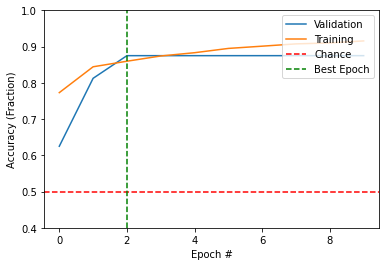

In [ ]:
# build CNN 
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense, Reshape, Dropout
from keras.layers import Flatten
from keras.regularizers import l2, l1
import keras
from keras.wrappers.scikit_learn import KerasClassifier

trainX = train_CNN2.iloc[:,0:1024]
trainY = to_categorical(train_CNN2[1024])


norm_val, val_labels = normalize(df_validate)

model = Sequential()
model.add(Reshape((32, 32, 1)))

model.add(Conv2D(32, (2,2), activation='relu', input_shape = (128, 128, 1)))
model.add(Dropout(0.8))
model.add(Flatten())
model.add(Dense(64, activation = 'relu', bias_regularizer=l2(0.01)))
model.add(Dense(2, activation = 'softmax' ))


opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

images2 = []
def unravel(data):
  for i in range(len(data)):
    img_arr = data[0][i]
    images2.append(img_arr.ravel())
    print(f"Image {i} done")
  return pd.DataFrame(images2)
validation_x = unravel(norm_val)
print(validation_x.shape)

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
val_labels = np.asarray(val_labels).astype('float32')
val_labels = to_categorical(val_labels)



history = model.fit(trainX, trainY, epochs = 10, validation_data=(validation_x, val_labels))
plot_acc(history)


In [ ]:
from sklearn import metrics
images = []
for i in range(len(norm_test)):
  img_arr = train_CNN[0][i]
  images.append(img_arr.ravel())
  print(f"Image {i} done")
test = pd.DataFrame(images)
pred = (model.predict(test))
print(test_labels)
pred[0:7]




Image 0 done
Image 1 done
Image 2 done
Image 3 done
Image 4 done
Image 5 done
Image 6 done
Image 7 done
Image 8 done
Image 9 done
Image 10 done
Image 11 done
Image 12 done
Image 13 done
Image 14 done
Image 15 done
Image 16 done
Image 17 done
Image 18 done
Image 19 done
Image 20 done
Image 21 done
Image 22 done
Image 23 done
Image 24 done
Image 25 done
Image 26 done
Image 27 done
Image 28 done
Image 29 done
Image 30 done
Image 31 done
Image 32 done
Image 33 done
Image 34 done
Image 35 done
Image 36 done
Image 37 done
Image 38 done
Image 39 done
Image 40 done
Image 41 done
Image 42 done
Image 43 done
Image 44 done
Image 45 done
Image 46 done
Image 47 done
Image 48 done
Image 49 done
Image 50 done
Image 51 done
Image 52 done
Image 53 done
Image 54 done
Image 55 done
Image 56 done
Image 57 done
Image 58 done
Image 59 done
Image 60 done
Image 61 done
Image 62 done
Image 63 done
Image 64 done
Image 65 done
Image 66 done
Image 67 done
Image 68 done
Image 69 done
Image 70 done
Image 71 done
Im

array([[0.3290667 , 0.6709333 ],
       [0.00857556, 0.99142444],
       [0.7027306 , 0.29726946],
       [0.03172481, 0.96827525],
       [0.06805082, 0.9319492 ],
       [0.01084237, 0.9891577 ],
       [0.36401036, 0.63598967]], dtype=float32)